In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string

In [129]:
#import gdown
#!gdown https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt
#!gdown https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

In [130]:
edgar_file = open('edgar_allan_poe.txt', 'r')
robert_file= open('robert_frost.txt', 'r')

In [131]:
nopunc1 = []
nopunc2 =[]
edgar = []
robert = []
for line in edgar_file:
    nopunc1 = [char for char in line if char not in string.punctuation]
    edgar.append("".join(nopunc1))
    
for line2 in robert_file:
    nopunc2 = [char for char in line2 if char not in string.punctuation]
    robert.append("".join(nopunc2))


In [132]:
edgar[:5]


['LO Death hath reard himself a throne\n',
 'In a strange city all alone\n',
 'Far down within the dim west\n',
 'Where the good and the bad and the worst and the best\n',
 'Have gone to their eternal rest\n']

In [133]:
robert[1:15]

['And sorry I could not travel both\n',
 'And be one traveler long I stood\n',
 'And looked down one as far as I could\n',
 'To where it bent in the undergrowth \n',
 '\n',
 'Then took the other as just as fair\n',
 'And having perhaps the better claim\n',
 'Because it was grassy and wanted wear\n',
 'Though as for that the passing there\n',
 'Had worn them really about the same\n',
 '\n',
 'And both that morning equally lay\n',
 'In leaves no step had trodden black\n',
 'Oh I kept the first for another day \n']

In [134]:
df1 = pd.DataFrame(edgar, columns = ['text'])
df1['label'] = 1
df2 = pd.DataFrame(robert, columns = ['text'])
df2['label'] = 0
df = pd.concat([df1,df2], axis=0)
df.head()


,text,label
0,LO Death hath reard himself a throne\n,1
1,In a strange city all alone\n,1
2,Far down within the dim west\n,1
3,Where the good and the bad and the worst and t...,1
4,Have gone to their eternal rest\n,1


In [178]:
df.tail()

,text,label
1576,\n,0
1577,A featherhammer gives a double knock\n,0
1578,This Eden day is done at two oclock\n,0
1579,An hour of winter day might seem too short\n,0
1580,To make it worth lifes while to wake and sport,0


C:\Users\e175932\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

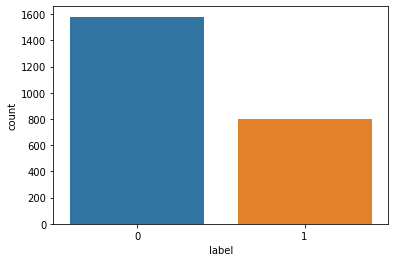

In [179]:
sns.countplot(df['label'])

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'])
print(len(X_train), len(X_test))

1783 595


1138    0
704     0
339     0
994     0
766     1
Name: label, dtype: int64

In [146]:
idx = 1
word2idx = {'<unk>': 0}
for text in X_train:
    tokens = text.split()
    for i in tokens:
        if i not in word2idx:
            word2idx[i] = idx
            idx += 1
            

In [149]:
len(word2idx)

2797

In [161]:
a = {'a':1, 'b':2}
dd = [a.get('c',3)]

In [162]:
dd

[3]

In [163]:
#convert data into integer format
train_int = []
test_int = []
for text in X_train:
    tokens = text.split()
    line_int = [word2idx[i] for i in tokens]
    train_int.append(line_int)
    
for text in X_test:
    tokens = text.split()
    line_int = [word2idx.get(i, 0) for i in tokens]
    test_int.append(line_int)


In [167]:
test_int[100:105]

[[670, 2, 11, 137, 67, 39, 872, 61],
 [39, 248, 0, 31, 0, 2074, 64],
 [198, 0, 56, 1229, 29, 609, 0, 129],
 [],
 [107, 0, 37, 970, 704, 0, 124]]

In [171]:
# initialize A and Pi matrices - for both classes
v = len(word2idx)
A0 = np.ones((v,v))
pi0 = np.ones(v)

A1 = np.ones((v,v))
pi1 = np.ones(v)

In [173]:
# compute counts for A and pi
def compute_counts(text_as_int, A, pi):
    for tokens in text_as_int:
        last_idx = None
        for idx in tokens:
            if last_idx is None:
                # its the first word in sentence
                pi[idx] += 1
            else:
                # the last word exist, so counts a transition
                A[last_idx, idx] += 1
            # update  last idx    
            last_idx = idx
            
compute_counts([t for t,y in zip(train_int, y_train) if y == 0], A0, pi0)
compute_counts([t for t,y in zip(train_int, y_train) if y == 1], A1, pi1)

In [180]:
# normalize A and Pi so they are valid probability matrices
A0 /= A0.sum(axis = 1, keepdims=True)
pi0 /= pi0.sum()

A1 /= A1.sum(axis = 1, keepdims = True)
pi1 /= pi1.sum()

#log A and Pi
logA0 = np.log(A0)
logpi0 = np.log(pi0)
logA1 = np.log(A1)
logpi1 = np.log(pi1)

In [182]:
# compute priors
count0 = sum(y == 0 for y in y_train)
count1 = sum(y == 1 for y in y_train)
total = len(y_train)
p0 = count0/ total
p1 = count1/ total 
logp0 = np.log(p0)
logp1 = np.log(p1)
print(p0, p1)

0.6528323051037577 0.3471676948962423


In [183]:
# Build a classifier 
class Classifier:
    def __init__(self, logAs, logpis, logpriors):
        self.logAs = logAs
        self.logpis = logpis
        self.logpriors = logpriors
        self.K = len(logpriors) #number of classes
        
    def _compute_log_likelihood(self, input_, class_):
        logA = self.logAs[class_]
        logpi = self.logpis[class_]
        
        last_idx = None
        logprob = 0
        for idx in input_:
            if last_idx is None:
                # its the first token 
                logprob += logpi[idx]
            else: 
                logprob += logA[last_idx, idx]
                
            #update last idx
            last_idx = idx
        return logprob
    
    def predict(self, inputs):
        predictions = np.zeros(len(inputs))
        for i, input_ in enumerate(inputs):
            posteriors = [self._compute_log_likelihood(input_, c) + self.logpriors[c] for c in range(self.K)] 
            pred = np.argmax(posteriors)
            predictions[i] = pred
        return predictions
    

In [184]:
#each array must be in order  since classes are assumed to index these lists 
clf = Classifier([logA0, logA1], [logpi0, logpi1], [logp0, logp1])

In [185]:
Ptrain = clf.predict(train_int)
print(f"Train acc: {np.mean(Ptrain == y_train)} " )

Train acc: 0.9629837352776219 


In [186]:
Ptest = clf.predict(test_int)
print(f"Test acc: {np.mean(Ptest == y_test)} ")

Test acc: 0.8369747899159664 


In [187]:
from sklearn.metrics import confusion_matrix, f1_score
confusion_matrix(y_test, Ptest)

array([[408,   9],
       [ 88,  90]], dtype=int64)

In [188]:
f1_score(y_test, Ptest)

0.6498194945848376